# Mission field analysis

We start the analisys of the enriched GTR dataset (see `01` and `02` notebooks)

## Mission field analysis

This notebooks analyses UK grant research data to produce indicators related to the government mission to 'transform the prevention, diagnosis and treatment of chronic diseases using AI'. 

Its input is a dataframe with information about UK research grants.

Its output is a series of indicators and charts about:

* Levels of activity in the mission
* Evolution of activity in the mission
* Feasibility of the mission
* Composition of the mission in terms of:
  * Disciplines
  * Actors
  * Trajectories

In order to measure levels of activity in the mission, we need to identify a mission field, calculated as the intersection betweeen AI research and research related to chronic diseases. This will require us to identify AI and chronic disease papers, which we will do using natural language processing.

## Preamble

In [1]:
%matplotlib inline

from scipy.stats import entropy

import matplotlib.pyplot as plt

plt.rc('font', family = 'serif',serif='Times New Roman') 

In [4]:
# %load lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()

def flatten_list(a_list):
    return([x for el in a_list for x in el])


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def ngram(self,threshold=10,times=1):
        '''
        Optional Create bigrams.
        
        '''
        
        counter = times
        
        while counter >0:
        
        #Colocation detector trained on the data
            phrases = models.Phrases(self.tokenised,threshold=threshold)
        
            bigram = models.phrases.Phraser(phrases)
        
            self.tokenised = bigram[self.tokenised]
            
            counter = counter -1
        
        return(self)
        
class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

## Load data

In [2]:
#Load projects
projects = pd.read_csv('/Users/jmateosgarcia/Desktop/gtr/gtr_data/data/processed/21_5_2019_combined_gtr_projects.csv',compression='zip')

In [2]:
#We focus on research grants
projects = projects.loc[projects.grant_category=='Research Grant'].reset_index(drop=True)

NameError: name 'projects' is not defined

## Identify relevant projects (AI and chronic diseases)

In [5]:
#Create sentence corpus
sentence_corpus = flatten_list([x.split('. ') for x in projects['abstract']])

#Tokenize etc using the classes above
sentence_tokenised = CleanTokenize(sentence_corpus).clean().ngram(times=2)

#Also tokenise by documents so we can query them later
corpus_tokenised = CleanTokenize(projects['abstract']).clean().ngram(times=2)


In [6]:
# with open(f'../models/{today_str}_word_embeddings.p','wb') as outfile:
#     pickle.dump(w2v,outfile)

In [7]:
def similarity_chaser(seed_list,model,similarity,occurrences=1):
    '''
    Takes a seed term and expands it with synonyms (above a certain similarity threshold)
    
    '''
    
    #All synonyms of the terms in the seed_list above a certain threshold
    set_ws = flatten_list([[term[0] for term in model.most_similar(seed) if term[1]>similarity] for seed in seed_list])
    
    #return(set_ws)
    
    #This is the list of unique occurrences (what we want to return at the end)
    set_ws_list = list(set(set_ws))
    
    #For each term, if it appears multiple times, we expand
    for w in set_ws:
        if set_ws.count(w)>occurrences:
            
            #As before
            extra_words = [term[0] for term in model.wv.most_similar(w) if term[1]>similarity]
            
            set_ws_list + extra_words
            
    #return(list(set(set_ws_list)))
    #return(set_ws_list)
    return(set_ws)

    
def querier(corpus,keywords):
    '''
    Loops over a tokenised corpus and returns varios measures indicating the presence of keywords in it.
    
    This includes:
    
    * Whether at least one keyword appears
    * How many keywords appear
    * What keywords appear
    
    
    '''
    #Empty dict with keywords
    #kw_dict = {k:[] for k in keywords}
    
    #Loop through the corpus and create a vectorised df of the keywords
    
    out = pd.concat([pd.Series({x:(doc.count(x)) for x in keywords}) for doc in corpus],axis=1).T
    
    
    #print(kw_dict)
    #Note that this also returns a sum of the keywords over the rows and a 
    return([out, out.sum(axis=1)])
    

#     #Intersection of tokens
#     if intersect==True:
    
#         out = [len(set(keywords) & set(document)) for document in corpus]
    
#     else:
#     #Otherwise it counts the total of tokens present in an abstract
        
#         out = [np.sum([x.count(k) for k in keywords]) for x in corpus]
    
    
    
    
    return(out)
    
    

### AI and Chronic diseases (crude keyword search-based)

In [8]:
#These are prototype words. 
ai_seed = ['machine_learning','artificial_intelligence','deep_learning','ai','machine_vision','text_mining','data_mining']
chronic_seed = ['chronic_disease','chronic_condition','addiction','alzheimers','atrial_fibrillation','autoimmune_disease',
               'lupus','bipolar_disorder','blindness','cerebral_palsy','chronic_hepatitis','depression','chronic_pain',
               'deafness','blindness','endometriosis','epilepsy','hiv','aids','huntingtons','hypertension','lyme',
               'sclerosis','parkinsons','sickle_cell','cancer','cardiovascular_disease','diabetes']


discs = [x for x in projects.columns if ('disc_' in x) & ('top' not in x)]

imps = [x for x in projects.columns if ('out_' in x)]

In [9]:
def random_check(corpus,num,length):
    '''
    Prints num random examples form corpus
    
    '''
    
    selected = np.random.randint(0,len(corpus),num)
    
    texts  = [text for num,text in enumerate(corpus) if num in selected]
    
    for t in texts:
        print(t[:length])
        print('====')

In [10]:
class missionKeywords():
    '''
    
    input: a list of projects with descriptions, dates, funding and outputs.
    
    -Expands keywords in a model (this could be clio or something else
    '''
    
    def __init__(self,projects,corpus_tokenised,model):
        '''
        
        Initialises the class with the projects and the w2v model we will use.
        
        '''
        
        self.projects = projects

        #This is the project df but with text description tokenised. We query it with the keywords 
        
        self.tokenised = corpus_tokenised
        self.w2v = model
        
        
    def keyword_expansion(self,mission_dict,thres):
        '''
        
        Expands a seed list of keywords. We input those as a dict where key corresponds to the type of input (solution or
        challenge, say) and the values are a list with the name of the entity (eg 'AI') and the seedlist to expand
        
        '''
        
        #Store the names eg 'challenge_chronic'
        self.names = [v[0] for k,v in mission_dict.items()]
        
        #Store the keywords
        self.keywords = [v[1] for k,v in mission_dict.items()]
        
        #Expand the keywords
        self.expanded_keywords = [list(set(kw + similarity_chaser(seed_list=kw,model=self.w2v,similarity=thres))) for
                                 kw in self.keywords]
        
        return(self)
        
    

In [11]:
class missionClassifier(missionKeywords):
    '''
    Classifies projects based on their keywords
    
    '''
    
    def __init__(self,missionKeywords):
        '''
        Initialise
        
        '''
        
        self.projects_labelled = missionKeywords.projects.copy()
        self.tokenised = missionKeywords.tokenised
        self.names = missionKeywords.names
        self.expanded_keywords = missionKeywords.expanded_keywords
    
    
    def filter_keywords(self,kws_to_drop):
        '''
        We can use it to drop irrelevant keywords. We 
        
        '''
                      
        #self.projects_labelled = self.projects_labelled[[x for x in self.projects_labelled.columns if x not in kws_to_drop]]
        
        self.expanded_keywords = [[x for x in kwset if x not in kws_to_drop] for kwset in self.expanded_keywords]
        
        
        return(self)
   
    
        
    
    def query_data(self,verbose=True):
        '''
        Queries the data with the keywords. It stores two attributes: the kw counts contain the counts by keywords 
        and challenge name; it also stores the projects labelled with an extra variable that
        counts the number of times that keywords in either set of keywords appears in the data.
        
        '''
        
        self.kw_counts = {}
        
        projects_labelled = self.projects_labelled
        tokenised = self.tokenised
        
        #We look for projects with keywords. Loop over name and extract the right index from the expanded keyword set.
        #This could also work as a dict.
        
        for num,name in enumerate(self.names):
            
            if verbose==True:
                print(name)
            
            outputs = querier(tokenised,self.expanded_keywords[num])
            
            self.kw_counts[name] = outputs[0]
            
            projects_labelled[name] = outputs[1]
            
        self.projects_labelled = projects_labelled
        
        return(self)
        
        
        
    

In [12]:
class missionProfiler(missionClassifier):
    '''
    Takes as input an instance of the class missionClassifier

    -Generates some descriptive statistics about the projects
    -Generates some graphs about the projects.
    
    '''
    
    def __init__(self,missionClassifier):
        '''
        
        Initialise
        '''
        
        self.projects_labelled = missionClassifier.projects_labelled.copy()
        self.names = missionClassifier.names.copy()
        self.expanded_keywords = missionClassifier.expanded_keywords.copy()
        
        self.column_names = [self.names[0]+'_and_'+self.names[1],self.names[0],self.names[1]]
    
    
    def mission_examples(self,n,length,text_var='abstract',thr=0):
        '''
        Prints n examples of missions using the text variable that was specified
        
        '''
        
        names = self.names
        
        for name in names:
            print(name)
            print('\n')
            
            random_check(corpus=list(self.projects_labelled.loc[self.projects_labelled[name]>thr,text_var]),
                         num=n,
                         length=200)
            
            print('\n')
        
        print(names[0]+' and ' + names[1])
        print('\n')
        random_check(corpus=list(self.projects_labelled.loc[
            (self.projects_labelled[names[0]]>thr) & (self.projects_labelled[names[1]]>thr),text_var]),
                         num=n,
                         length=length)
            
        
        
    def mission_field_basics(self,field_filter=[0,0],verbose=True):
        '''
        Generates estimates of activity in a field. field_filter refers to whether
        '''
        
        projects = self.projects_labelled
        names = self.names
        
        #Do the filter. Note that we assume that the user here will have done some EDA of the results to choose the right
        #filter.
        
        #Binarise. Note that the default assumes that the values here are a 
        for num,n in enumerate(names):
            projects[n] = projects[n].apply(lambda x: 1 if x> field_filter[num] else 0)
            
        
        
        #What's the size of the potential and effective mission field?
        #TODO: generalise to more than two fields.
        
        #Potential mission field
        union = projects.loc[(projects[names[0]]==True)|(projects[names[1]]==True),:]

        #Active mission field
        intersection = projects.loc[(projects[names[0]]==True)& (projects[names[1]]==True),:]

        #field 0 totals
        field_0 = projects.loc[(projects[names[0]]==True),:]

        #Fields 1 totals
        field_1 = projects.loc[(projects[names[1]]==True),:]
        
        #We are not very interested in the union of fields
        self.sets = [intersection,field_0,field_1]

        summary = {names[0]+'_or_'+names[1]:len(union),
                   names[0]+'_and_'+names[1]:len(intersection),
                   names[0]+'_total':len(field_0),
                   names[1]+'_total':len(field_1)}
        
        if verbose==True:
            print(summary)
        
        #Store the mission summary
        self.mission_summary = summary
        
               
        #Mission basics (over / underrepresentation of )
        mission_basics = pd.Series([100*len(intersection)/len(field_0),100*len(field_1)/len(projects),
                                    100*len(intersection)/len(field_1),100*len(field_0)/len(projects)],
               index=[names[0]+'_and_'+names[1]+'as_share_of_'+names[0],
                      names[1]+'_as_share_of all',
                      names[0]+'_and_'+names[1]+'_as_share_of'+names[1],
                      names[0]+'_as_share_of all'])
        
        self.mission_basics = mission_basics
        
        return(self)
        
    def mission_trends(self,years=[2006,2019],funding=False,year_var='year'):
        '''
        Calculates mission trends over time.
        
        '''
        
        #Extract projects
        projects =self.projects_labelled
        
        names = self.names
        
        #Results dict
        
        self.trends = {}
        
        
        #####
        #Year trends
        #####
        
        #Year counts for each variable of interest
        trends = pd.concat([df[year_var].value_counts(normalize=1) for df in self.sets],axis=1)
        
        trends.columns =self.column_names
        
        project_trends = trends.loc[(trends.index>years[0]) & (trends.index<years[1])]
        
        self.trends['project_trends'] = project_trends
        
        
        #And also look at funding (if available)
        if funding!=False:
            
            #This calculates totals of funding and normalises over the interval to see if recent periods have more activity
            
            funding_trends = pd.concat([df.groupby(year_var)[funding].sum() for df in self.sets],axis=1)
            
            funding_trends.columns = self.column_names
            
            funding_norm = funding_trends.apply(lambda x: x/x.sum(),axis=0)
            
            funding_norm = funding_norm.loc[(funding_norm.index>years[0]) & (funding_norm.index<years[1])]

            self.trends['funding_trends'] = funding_norm
    
        
        ####
        #Yearly shares
        ####
        
        #Normalises for each period. NB there is a loooot of repetition below. Need to refactor.
        
        trends_as_share = pd.concat([df.year.value_counts() for df in self.sets],axis=1)

        trends_as_share.columns = self.column_names

        #This gets the number of projects in the mission as a share of the total
        trends_as_share[
            f'mission_field_share_{names[0]}'],trends_as_share[f'mission_field_share_{names[1]}'] = [
            trends_as_share.iloc[:,0]/trends_as_share.iloc[:,num] for num in [1,2]]
        
        trends_as_share = trends_as_share.loc[(trends_as_share.index>years[0]) & (trends_as_share.index<years[1])]
        
        self.trends['project_shares'] = trends_as_share
        
        #And also funding (if available)
        
        if funding != False:
            
            #We use the funding trend df from above
            funding_as_share = funding_trends.copy()
            
            funding_as_share[
                f'mission_field_share_{names[0]}'],funding_as_share[f'mission_field_share_{names[1]}'] = [
                funding_as_share.iloc[:,0]/funding_as_share.iloc[:,num] for num in [1,2]]
            
            funding_as_share = funding_as_share.loc[(funding_as_share.index>years[0]) & (funding_as_share.index<years[1])]
            
            self.trends['funding_shares'] = funding_as_share
            
        return(self)
            
            
    def funder_trends(self,years=[2006,2019],funder_var='funder',year_var='year',funding=False):
        '''
        Funding plots
        
        '''
        
        
        self.funders = {}
        
        names = self.names
        
        #####
        #Funding totals
        ####
        
        #As before... this gets funder shares of activity
        funders = pd.concat([df[funder_var].value_counts(normalize=1) for df in self.sets],axis=1)

        funders.columns = self.column_names
        
        self.funders['funder_projects'] = funders
        
        #If we want to look at funding
        
        if funding != False:
            funding_shares = pd.concat([df.groupby(funder_var)[funding].sum() for df in self.sets],axis=1)
            
            funding_shares = funding_shares.apply(lambda x: x/x.sum(),axis=0)
            
            funding_shares.columns = self.column_names
        
            self.funders['funder_funding'] = funding_shares

        ######
        #Funding trends
        ######
        
        mission_field = self.sets[0]
        
        self.funders['funder_project_trends'] = pd.crosstab(mission_field[year_var],mission_field[funder_var])
        
        if funding != False:
            
            funder_funding_trends = mission_field.groupby([year_var,funder_var])[funding].sum()
            
            
            
            self.funders['funder_funding_trends'] = pd.pivot_table(
                funder_funding_trends.reset_index(drop=False),index=year_var,columns=funder_var,values=funding).fillna(0)
            
        return(self)
            
            
    def discipline_analysis(self,disc_vars = discs,thres=0.1):
        '''
        Estimates rough measures of interdisciplinarity for projects
        '''
        
        #Calculates the entropy for each project and stores it in the sets
        self.sets[0]['entropy'],self.sets[1]['entropy'],self.sets[2]['entropy'], = [
            df[disc_vars].apply(entropy,axis=1) for df in self.sets]
        
        
        disc_distr = pd.concat([df[disc_vars].applymap(lambda x: x>thres).sum(axis=1).value_counts(normalize=True) 
                                  for df in self.sets],axis=1).fillna(0)


        disc_distr.columns = self.column_names
        
        
        self.discipline_mix = disc_distr
        
        return(self)
        
        

    def impact_mix(self,years=[2006,2019],year_var='year',impact_vars=imps):
        
        '''
        Compares impact stats in different fields.
        '''
        
        
        imps_share = pd.concat([df.loc[
            (df[year_var]>years[0]) & (df[year_var]<years[1]),impact_vars].mean() for df in self.sets],axis=1)
        
        imps_share.columns = self.column_names

        imps_norm = imps_share.T/imps_share.T.mean()
        
        self.impacts = [imps_share,imps_norm]
        
        return(self)
    
        
        
        
           

#### Classify projects into categories using the expanded keyword search

In [13]:
# #Create sentence corpus
# sentence_corpus = flatten_list([x.split('. ') for x in projects['abstract']])


# #Tokenize etc using the classes above
# sentence_tokenised = CleanTokenize(sentence_corpus).clean().ngram(times=2)

# #Also tokenise by documents so we can query them later
# corpus_tokenised = CleanTokenize(projects['abstract']).clean().ngram(times=2)


#### Here we will do some grid search to figure out what strategies for expansion generate better results.

We perform this search with the window for the `Word2vec` model and with the similarity in the search





In [14]:
window_frame = [1,5,10,15,20,25]

similarity_interval = [0.7,0.75,0.8,0.85,0.9]

In [15]:
from itertools import product

combs = list(product(window_frame,similarity_interval))

In [16]:
#My idea here is to extract the keywords for different combinations of parameters and then look at their distributioin. Keywords that appear frequently are more 
#likely to be related to the initial seed.

kws = []

for n,item in enumerate(combs):
    
    print(n)
    
    #Train the word2vec model using the window parameter
    w2v_model = Word2Vec(sentence_tokenised.tokenised,window=item[0])
    
    #Initialise the mission keyword expander and expand
    mk = missionKeywords(projects,corpus_tokenised.tokenised,w2v_model)

    mission_dict = {'solution':['ai',ai_seed],'challenge':['chronic_condition',chronic_seed]}

    mk.keyword_expansion(mission_dict,thres=item[1])
    
    
    
    kws.append(mk)

0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [17]:
#Now we extract the labels generated by the keywords identified in each of the models


labels = []

for n,ob in enumerate(kws):
    mc = missionClassifier(ob)
    mc.query_data()
    
    labs = mc.projects_labelled[['project_id','ai','chronic_condition']]
    
    labs.columns = [x+f'_model_{n}' for x in labs.columns]
    
    labels.append(labs)

ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition
ai
chronic_condition


Next step is to label the projects with a % of models that classify them as AI and validate their performance manually: what models strike the best precision-recall trade-off?

In [18]:
#This calculates the % of models that flag a case in a category
models_conc= pd.concat([x.iloc[:,1:] for x in labels],axis=1)

In [19]:
#
models_conc['ai_share'],models_conc['chronic_share'] = [models_conc.loc[:,[var in col for col in models_conc.columns]].applymap(lambda x: x>0).mean(axis=1) for 
                                                       var in ['ai_','chronic_']]

In [20]:
models_conc.index=labels[0].iloc[:,0]

## Manual validation / annotation

In [ ]:
#We will use this abstract lookup later
abstract_lookup = {row['project_id']:row['abstract'] for i,row in mc.projects_labelled.iterrows()}

In [ ]:
#Here we identify which projects have ai / chronic diseases. We only keep the relevant variable for each model
has_ai,has_chronic = [pd.DataFrame(models_conc.loc[models_conc[var]>0][var]) for var in ['ai_share','chronic_share']]

In [ ]:
# Now we calculate the deciles inside each of the groups

has_ai['quarts'], has_chronic['quarts'] = [pd.qcut(df[var],q=np.arange(0,1.1,0.1),duplicates='drop',
                                                  labels=False) for df,var in zip([has_ai,has_chronic],['ai_share','chronic_share'])]

In [ ]:
#Now we calculate the sets. Here, for every df and quantile we have an element with all ids in the set (chosen above the threshold) and
#all ids not in the set (not chosen below the threshold). We look for precision in the first element and recall in the second

has_ai_ids = [[set([i for i,row in has_ai.iterrows() if row['quarts']>n]),
                                set([i for i,row in has_ai.iterrows() if row['quarts']<n])] for n in [0,2,4,6,7]]

#Need to check why there are less deciles in the chronic case
has_chronic_ids = [[set([i for i,row in has_chronic.iterrows() if row['quarts']>n]),
                                set([i for i,row in has_chronic.iterrows() if row['quarts']<n])] for n in [0,2,4]]


In [ ]:
import random
random.seed(888)

In [ ]:
#Remember that we will not test the recall for the first group (it contains all elements)


assessment = []

for n,group in enumerate(has_ai_ids[1:]):
    
    #For each group in the df, we extract 10 random elements from the first element, and vote them, and 10 random elements from the second,
    #and we vote them.
    
    results =[[],[]]
    
    for n in [0,1]:
        
        test_set = random.sample(group[n],10)
        
        for element in test_set:
        
            print(abstract_lookup[element])
            
            print('\n')
            
            val =  input('is it AI?')
            
            results[n].append(int(val))
            
            print('\n')
            print('\n')
            
            
    assessment.append(results)
    
    

In [ ]:
#Here we evaluate performance over our 80 evaluations 
evaluation_ai = pd.DataFrame([[np.mean(x[0]),np.sum(x[0])/(np.sum(x[0])+np.sum(x[1]))] for x in assessment],columns=['Precision','Recall'],
                            index=['d_2','d_4','d_6','d_7'])

We will choose AI and Chronic disease projects with a score above 7.

#### Intermediate analysis: Plot keyword frequencies

## Mission field analysis

This is going to require some changes as we are using a different pipeline to identify AI and Chronic disease projects now

#### Run the mission profiler

In [ ]:
#Initialise the mission profiler

mprof = missionProfiler(mc)

#Change the names we want to focus on
mprof.names =['ai_2','chronic_disease_2']

#Change the variables we want to focus on
mprof.projects_labelled['ai_2'],mprof.projects_labelled['chronic_disease_2'] = [[x in sel_df[0] for x in mprof.projects_labelled['project_id']] for
                                                                                sel_df in [has_ai_ids[-3],has_chronic_ids[-1]]]

In [ ]:
mprof.projects_labelled[['ai_2','chronic_disease_2']].sum()

In [ ]:
mprof.mission_field_basics().mission_trends(funding='amount').funder_trends(funding='amount').discipline_analysis().impact_mix()

### Summary chart

In [ ]:
fig,ax = plt.subplots(figsize=(5,3.5))

pd.DataFrame(mprof.mission_summary,index=['total']).T.plot.bar(color=['blue','red','orange','red'],ax=ax,legend=False)

ax.set_xticklabels(['Potential mission field','Active mission field','AI total','Chronic condition total'],rotation=45,
                   ha='right')

ax.set_ylabel('Number of projects')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_2_summary.pdf')

### Print some examples

In [ ]:
example_projs = mprof.projects_labelled.loc[(
    mprof.projects_labelled.ai_2>0) & (mprof.projects_labelled.chronic_disease_2>0)][['title','abstract']]

random = example_projs.iloc[np.random.randint(0,len(example_projs),3)]

random_list = [[x,y] for x,y in zip(random['title'],random['abstract'])]

          
          
for el in random_list:
    print('TITLE: '+el[0])
    print('====')
    print('ABSTRACT EXCERPT: '+el[1][:1000])
    print('\n')



In [ ]:
fig,ax = plt.subplots(figsize=(8,8))

mprof.mission_basics.plot.bar(color=['orange','blue','orange','blue'],ax=ax)

ax.set_xticklabels(['Chronic disease as share of AI','Chronic as share of all',
                    'AI as a share of chronic condition','AI as share of all'],rotation=45,ha='right',size=14)

ax.yaxis.set_tick_params(labelsize=14)


ax.set_ylabel('%',size=18)

ax.set_title('Representation of AI and Chronic Disease \n in the population of research and in the mission field',size=18)

plt.tight_layout()

plt.savefig('../reports/figures/presentation/topic_representation.pdf')

Z-test of differences in proportions

In [ ]:
distr = pd.crosstab(mprof.projects_labelled['ai_2'],mprof.projects_labelled['chronic_disease_2'])

from statsmodels.stats.proportion import proportions_ztest

In [ ]:
#Test AI: is the proportion of AI projects drawn from the population higher than the proportion of projects drawn from the chronic disease set?

ai_counts = np.array(distr.iloc[1])
all_counts = np.array(distr.iloc[0])

proportions_ztest(ai_counts,all_counts,alternative='larger')

In [ ]:
#Test AI: is the proportion of AI projects drawn from the population higher than the proportion of projects drawn from the chronic disease set?

cd_counts = np.array(distr[1])
all_counts = np.array(distr[0])

proportions_ztest(cd_counts,all_counts,alternative='larger')

Differences are significant in all cases

In [ ]:
mprof.projects_labelled.loc[(mprof.projects_labelled['ai_2']>0) & (mprof.projects_labelled['chronic_disease_2']>0)]['amount'].sum()/1e6

#### Trends

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(16,6),
                    sharex='row')

(100*mprof.trends['project_trends']).rolling(window=4).mean().plot(ax=ax[0])
(100*mprof.trends['project_shares']).iloc[:,-2:].rolling(window=4).mean().plot(ax=ax[1])



ax[0].set_ylabel('Year as % of total (projects)',size=18)
ax[1].set_ylabel('Year as % of total (funding)',size=18)

#ax[0][1].set_ylabel('Year as % of total (projects)',size=18)
#ax[1][1].set_ylabel('Year as % of total (funding)',size=18)


ax[0].legend(fontsize=14,labels=['Active Mission field','AI','Chronic Condition'])
ax[1].legend(fontsize=14,labels=['Active Mission field as a share of AI','Active mission field as a share of chronic disease'])


ax[0].set_ylim([4,12.5])
ax[1].set_ylim([0,12.5])

ax[0].xaxis.set_tick_params(labelsize=14)
ax[1].xaxis.set_tick_params(labelsize=14)

fig.suptitle('Evolution in levels of activity (rolling means, 4 year window)',size=18,y=1.02)

plt.tight_layout()

plt.savefig('../reports/figures/presentation/fig_4_trends.pdf',bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(nrows=2,figsize=(11.5,9),ncols=2,
                    sharex='row'
                      )

(100*mprof.trends['project_trends']).rolling(window=4).mean().plot(ax=ax[0][0])
(100*mprof.trends['funding_trends']).rolling(window=4).mean().plot(ax=ax[1][0],legend=False)

(100*mprof.trends['project_shares']).iloc[:,-2:].rolling(window=4).mean().plot(ax=ax[0][1])
(100*mprof.trends['funding_shares']).iloc[:,-2:].rolling(window=4).mean().plot(ax=ax[1][1],legend=False)

ax[0][0].set_ylabel('Year as % of total (projects)',size=18)
ax[1][0].set_ylabel('Year as % of total (funding)',size=18)

ax[0][1].set_ylabel('Category as % in year (projects)',size=18)
ax[1][1].set_ylabel('Category as % in year (funding)',size=18)


ax[0][0].set_ylim([4,12.5])
ax[0][1].set_ylim([0,12.5])

ax[0][0].legend(fontsize=14,labels=['Active Mission field','AI','Chronic Condition'])
ax[0][1].legend(fontsize=14,labels=['Active Mission field as a share of AI','Active mission field as a share of chronic disease'])


ax[1][0].xaxis.set_tick_params(labelsize=14)
ax[1][1].xaxis.set_tick_params(labelsize=14)

fig.suptitle('Evolution in levels of activity (rolling means, 4 year window)',size=18,y=1.02)

plt.tight_layout()

plt.savefig('../reports/figures/presentation/trends.pdf',bbox_inches='tight')

#### Funding

The funder for the mission fied might be different from the funder for the constituent parts. I would expect the mission funder to be related (closer) to the challenge.

In [ ]:
fig, ax = plt.subplots(figsize=(4,8),nrows=2)

mprof.funders['funder_projects'].T.plot.bar(stacked=True,ax=ax[0],width=0.8)
mprof.funders['funder_funding'].T.plot.bar(stacked=True,ax=ax[1],width=0.8)

ax[0].legend(bbox_to_anchor=(1,1))
ax[1].legend().set_visible(False)

#### Discipline mix

The effective mission field will contain a higher level of discipline diversity than the constituent parts (although here we need to remember that the constituent parts might also be related to other missions we are not capturing).

In [ ]:
fig,ax = plt.subplots(figsize=(10,4.5))

_ = [ax.hist(df['entropy'],bins=20,color=col,alpha=0.6,density=True) for df,col in zip(mprof.sets,['blue','orange','green'])]

ax.legend(['Active Mission field','AI','Chronic diseases'],fontsize=16)

ax.set_title('Discipline diversity by group',size=24)

ax.set_ylabel('Density',size=16)
ax.set_xlabel('Entropy',size=16)

plt.tight_layout()
plt.savefig('../reports/figures/presentation/diversity.pdf',bbox_inches='tight')


In [ ]:
fig,ax = plt.subplots(figsize=(6,4))

(100*mprof.discipline_mix.T).plot.bar(ax=ax)

ax.set_xticklabels(['AMF','AI','Chronic disease'],rotation=45,ha='right',fontsize=14)

ax.legend(bbox_to_anchor=[1,1],title='Disciplines per project',fontsize=14)
ax.set_ylabel('% of projects',fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_7_disc_mix.pdf')


##### Classify projects into their top discipline and track its evolution

In [ ]:
fig,ax= plt.subplots(figsize=(8,4.5))

plot_df = pd.concat([df[discs].idxmax(axis=1).value_counts(normalize=True) for df in mprof.sets],axis=1)

discs_ord = plot_df.sort_values(0).index

(100*plot_df.loc[discs_ord[::-1]]).T.plot.bar(stacked=True,ax=ax,width=0.8,cmap='Accent_r',edgecolor='grey')

ax.set_xticklabels(['AMF','AI','Chronic diseases'],rotation=45,ha='right',size=14)
ax.legend(bbox_to_anchor=[1,1],title='Discipline',fontsize=14,
         labels=['Physics','Environmental','Mathematics & Computing','Medical','Engineering & Technology','Biological','Arts and Humanities','Sosical Sciences'])
ax.set_ylabel('Discipline as share of total',size=16)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_title('Discipline distribution by category',size=18)

plt.tight_layout()
plt.savefig('../reports/figures/presentation/disc_mix.pdf')

### Discipline mix over time

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))

pd.crosstab(
    mprof.sets[0].year,mprof.sets[0][discs].idxmax(axis=1),normalize=False).rolling(
    window=4).mean().loc[np.arange(2006,2019),discs_ord[::-1]].plot.bar(stacked=True,ax=ax,width=0.9)

ax.legend(title='discipline')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_6_disc_evol.pdf')

### Discipline crossover

In [ ]:
sorted_discs = mprof.sets[0][discs].sum().sort_values().index[::-1]

In [ ]:
# th = 0.2

# fig,ax =plt.subplots(figsize=(10,4),ncols=3,sharey=True)

# sns.heatmap(remove_diagonal(
#     jacc_dists[0],val=np.nan),cmap='seismic',ax=ax[0])

# ax[0].set_title('Active mission field')

# sns.heatmap(remove_diagonal(
#     jacc_dists[1],val=np.nan),cmap='seismic',ax=ax[1])

# ax[1].set_title('AI')

# sns.heatmap(remove_diagonal(
#     jacc_dists[2],val=np.nan),cmap='seismic',ax=ax[2])

# ax[2].set_title('Chronic disease')

# plt.tight_layout()

# plt.savefig('../reports/figures/working_paper/fig_8_disc_mix.pdf')


In [ ]:
import seaborn as sns

def remove_diagonal(df,val=0):
    '''
    Removes the diagonal in a square df. Otherwise the colourscale is drowned by the corr=1 
    
    '''
    
    for c in df.columns:
        for r in df.index:
            if c==r:
                df.loc[r,c]=val
                
    return(df)

In [ ]:
th = 0.2

fig,ax =plt.subplots(figsize=(10,4),ncols=3,sharey=True)

sns.heatmap(remove_diagonal(
    mprof.sets[0][sorted_discs].applymap(lambda x: 1 if x>th else 0).corr(),val=np.nan),cmap='seismic',ax=ax[0])

ax[0].set_title('Active mission field')

sns.heatmap(remove_diagonal(
    mprof.sets[1][sorted_discs].applymap(lambda x: 1 if x>th else 0).corr(),val=np.nan),cmap='seismic',ax=ax[1])

ax[1].set_title('AI')

sns.heatmap(remove_diagonal(
    mprof.sets[2][sorted_discs].applymap(lambda x: 1 if x>th else 0).corr(),val=np.nan),cmap='seismic',ax=ax[2])

ax[2].set_title('Chronic disease')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_8_disc_mix.pdf')


### Identify crossover collaborations

We use a modified version of the function that extracts networks from document-term matrices

In [ ]:
from itertools import combinations
import networkx as nx

def make_network_from_doc_term_matrix(dt_matrix,weight_filter=False,edgelist=False):    
    '''
    Takes a document-term matrix and returns a network.
    Offers the option to filter the network based on its weights (the parameter is a quantile if !=False)
    
    '''
    
    
    #Melt the data so we have a project-kw df
    long_topics = pd.melt(dt_matrix.reset_index(drop=False),id_vars='index')

    #Remove terms not happening in a project (Note that this throws away instances where a term occurs multiple times in a doc)
    topics_grouped = long_topics.loc[long_topics.value>0,:].groupby('index')['variable'].apply(lambda x: list(x))
    
    #And now we want to tun this into an edge list
    #This extracts pairs of combinations from topics in a project, sorts them and counts how many there are.

    edge_list = pd.Series('&&'.join(pair) for pair in flatten_list(
        [sorted(combinations(x,2),key=lambda x: x[0],reverse=False) for x in topics_grouped])).value_counts()
    
    
    #This creates the edge list in a format that can be read by nx
    edge_list = pd.concat([pd.Series({'source':v.split('&&')[0],
                                      'target':v.split('&&')[1], 'weight':l}) for v,l in zip(edge_list.index,edge_list)],axis=1).T
    
    
    #Create the network
    net = nx.from_pandas_edgelist(edge_list,edge_attr='weight')

    if weight_filter!=False:
        
        #Filter edges to focus on larger connections

        #Find the top quantile
        quant = pd.Series(list(dict(net.degree).values())).quantile(q=weight_filter)

        sub_g = [(u,w) for u,w,attr in net.edges.data(data=True) if attr['weight']>quant]

        net = net.edge_subgraph(sub_g)
        
    if edgelist==False:
        return(net)
    else:
        return(edge_list)

In [ ]:
fig,ax = plt.subplots(figsize=(10,7))

freqs = [make_network_from_doc_term_matrix(df[discs].applymap(lambda x: 1 if x>0.1 else 0),edgelist=True)
                   for df in mprof.sets]

freqs_processed = []

for num,x in enumerate(freqs):
    x['comb'] = [x+' WITH '+y for x,y in zip(x['source'],x['target'])]
    
    x.set_index('comb',inplace=True)
    
    freqs_processed.append(x['weight']/len(mprof.sets[num]))
    
out = pd.concat(freqs_processed,axis=1).fillna(0)

out.columns = ['AMF','AI','Chronic']


(100*out.sort_values('AMF')[out.columns[::-1]]).plot.barh(ax=ax)

ax.set_xlabel('% of all projects')


plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_9_disc_combs.pdf')



### Top disciplines

In [ ]:
fig,ax= plt.subplots()


plot_df = pd.concat([df[discs].idxmax(axis=1).value_counts(normalize=True) for df in mprof.sets],axis=1)

discs_ord = plot_df.sort_values(0).index

plot_df.loc[discs_ord[::-1]].T.plot.bar(stacked=True,ax=ax,width=0.8)

ax.set_xticklabels(['AMF','AI','Chronic diseases'],rotation=45,ha='right')
ax.legend(bbox_to_anchor=[1,1],title='Discipline')
ax.set_ylabel('Discipline as share of total')

plt.tight_layout()
plt.savefig('../reports/figures/working_paper/fig_5_disc_mix')

### Impacts

In [ ]:
mprof.impacts[1].plot.bar()

In [ ]:
#Here we focus on the more recent period (taking into account that the AI / chronic projects tend to be more recent)
fig,ax = plt.subplots(figsize=(6.5,4))


mprof.impact_mix(years=[2012,2018]).impacts[1].plot.bar(ax=ax)


ax.set_ylabel('Relative specialisation index',size=14)
ax.hlines(y=1,xmin=-1,xmax=3,linestyles=':')

ax.set_xticklabels(['AMF','AI','Chronic'],size=14)
ax.legend(bbox_to_anchor=[1,1],title='Output type',fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_10_outputs.pdf')


In [ ]:
100*mprof.sets[0][imps].applymap(lambda x: x>0).mean()

### Network analysis

Now we want to visualise the organisational network of the mission field: what organisations are connected with each other in this network?

Who are the key players in each of the three 'fields' (chronic, AI and AI-chronic), in total number of projects and relative specialisation?







In [ ]:
links = pd.read_csv('../data/external/gtr/2019-01-24/gtr_link_table.csv')
orgs = pd.read_csv('../data/external/gtr/2019-01-24/gtr_organisations.csv')

The logic below is:

``merge projects and links on project ids, and merge that with organisations on entity ids``


In [ ]:
#We want to avoid cofunding organisations, fellow organisations etc

my_vars = ['COLLAB_ORG','LEAD_ORG','PARTICIPANT_ORG']

In [ ]:
project_orgs = pd.merge(
    pd.merge(mprof.projects_labelled,links.loc[links.table_name=='gtr_organisations'],left_on='project_id',right_on='project_id'),
    orgs[['id','name']],left_on='id',right_on='id')

projects_orgs = project_orgs.loc[[x in my_vars for x in project_orgs['rel']],:]

In [ ]:
project_orgs['ai_2_and_chronic_disease_2'] = [(x>0) & (y>0) for x,y in zip(project_orgs['ai_2'],project_orgs['chronic_disease_2'])]

#### Are organisations in active mission fields younger?

Here we proxy age through the earliest when an organisation appears in the data

In [ ]:
def calculate_ages(three_sets,org_df,stat):
    '''
    Calculates the mean ages for organisations participating in different mission fields
    
    '''
    
    new_df = org_df.copy()
    
    #AMF = active mission field
    new_df['ai'],new_df['chronic'], new_df['amf'] = [[x in v for x in new_df.index] for v in three_sets]
    
    #Calculate mean age of organisations in a field (time since they first appeared in the data)
    youth = pd.concat([2019-new_df.groupby(var)['year'].apply(lambda x: stat(x)) for var in ['amf','ai','chronic']],axis=1)
    youth.columns=['amf','ai','chronic']
    
    return(youth)

In [ ]:
#Min age of appearance by organisation
org_metadata = pd.concat([
    project_orgs.groupby('name')['year'].apply(lambda x: min(x)),
    project_orgs.groupby('name').size()],axis=1)
    
org_metadata.rename(columns={0:'project_number'},inplace=True)


In [ ]:
#All organisations in the field
org_sets =[set(project_orgs.loc[project_orgs[var]>0]['name']) for var in ['ai_2','chronic_disease_2','ai_2_and_chronic_disease_2']]

#Organisations that *only* participate in the field
org_set_specs =[
    set(project_orgs.loc[project_orgs[var]>0]['name'])-set(project_orgs.loc[project_orgs[var]==0]['name']) for var in ['ai_2',
                                                                                                                       'chronic_disease_2',
                                                                                                                       'ai_2_and_chronic_disease_2']]

In [ ]:
out = pd.concat([calculate_ages(org_sets,org_metadata,np.mean).loc[True],
          calculate_ages(org_set_specs,org_metadata,np.mean).loc[True]],axis=1)

out.columns = ['All','Specialised']

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))

out.T.plot.bar(ax=ax)

ax.set_ylabel('Number of years \n since first appearance',size=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)


ax.legend(fontsize=13,labels=['Active Mission field','AI','Chronic disease'])

ax.set_title('Project participant experience',size=18)

plt.tight_layout()

plt.savefig('../reports/figures/presentation/participants_experience.pdf')

In [ ]:
def calculate_experience(three_sets,org_df,stat):
    '''
    Calculates the experience for organisations participating in different mission fields
    
    '''
    
    new_df = org_df.copy()
    
    #AMF = active mission field
    new_df['ai'],new_df['chronic'], new_df['amf'] = [[x in v for x in new_df.index] for v in three_sets]
    
    #Calculate mean age of organisations in a field (time since they first appeared in the data)
    youth = pd.concat([new_df.groupby(var)['project_number'].apply(lambda x: stat(x)) for var in ['amf','ai','chronic']],axis=1)
    youth.columns=['Active Mission field','AI','Chronic Diseases']
    
    return(youth)

In [ ]:
out_2 = pd.concat([calculate_experience(org_sets,org_metadata,np.median).loc[True],
          calculate_experience(org_set_specs,org_metadata,np.median).loc[True]],axis=1)

out_2.columns = ['All','Specialised']

fig,ax = plt.subplots(figsize=(5,3.5))

out_2.T.plot.bar(ax=ax)

ax.set_ylabel('Average number of projects')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_12_experience.pdf')

### Total organisation frequencies

In [ ]:
total_org_freqs = project_orgs['name'].value_counts(normalize=1)

var_names = ['ai_2','chronic_disease_2','ai_2_and_chronic_disease_2']

mission_org_freqs = pd.concat([
    project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1) for var in var_names],axis=1).fillna(0)

mission_org_freqs.columns=var_names

fig,ax = plt.subplots(figsize=(5,10))

mission_org_freqs.loc[total_org_freqs.index[:50]][::-1].plot.barh(ax=ax,title=
                                                                  'Share of activity in relevant areas for top research organisations in the UK')

Note that the EPSRC and the MRC are still there (?)

In [ ]:
# Now do it with some normalisation

mission_org_freqs_norm = pd.concat([
    project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1)/total_org_freqs for var in var_names],axis=1).fillna(0)

mission_org_freqs_norm.columns=var_names

fig,ax = plt.subplots(figsize=(10,10))

mission_org_freqs_norm.loc[total_org_freqs.index[:200]].sort_values('ai_2_and_chronic_disease_2',ascending=True)[-50:].plot.barh(
    ax=ax,title='Organisations with high specialisation in the mission field')

ax.set_yticklabels([x.get_text()[:40] for x in ax.get_yticklabels()])

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_13_top_actors.pdf')

In [ ]:
top_50_total = set(mission_org_freqs.loc[total_org_freqs.index[:50]].index)
top_50_mission = set(mission_org_freqs_norm.loc[total_org_freqs.index[:200]].sort_values('ai_2_and_chronic_disease_2',ascending=False)[:50].index)


set(top_50_mission) & set(top_50_total)



In [ ]:
#Compare share of total AI, Chronic, Chronic condition

mission_distribution = pd.concat([pd.concat([project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1) for var in var_names],axis=1).fillna(0),
                                  total_org_freqs],axis=1).fillna(0)

mission_distribution.columns=var_names + ['total']

sns.heatmap(remove_diagonal(mission_distribution.corr(method='spearman')),cmap='viridis',annot=True)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_14_rankings_heatmap.pdf')

Interesting - it looks like organisations that are strong in AI tend to apply it in other areas rather than the other way around.

#### Conclude with a network visualisation

In [ ]:
def make_network_from_element_lists(element_list,index='index',variable='variable',weight_filter=False):    
    '''
    Takes a list where every element is a list of elements
    Offers the option to filter the network based on its weights (the parameter is a quantile if !=False)
    
    '''
    
    
    #Remove terms not happening in a project (Note that this throws away instances where a term occurs multiple times in a doc)
    topics_grouped = element_list.groupby(index)[variable].apply(lambda x: list(x))
    
    #And now we want to tun this into an edge list
    #This extracts pairs of combinations from topics in a project, sorts them and counts how many there are.

    edge_list = pd.Series('&&'.join(pair) for pair in flatten_list(
        [sorted(combinations(x,2),key=lambda x: x[0],reverse=False) for x in topics_grouped])).value_counts()
    
    
    e1,e2 = [[x.split('&&')[num] for x in edge_list.index] for num in [0,1]]

    edge_df= pd.DataFrame({'source':e1,'target':e2,'weight':edge_list}).reset_index(drop=True)
    
    
    #Create the network
    net = nx.from_pandas_edgelist(edge_df,edge_attr='weight')

    if weight_filter!=False:
        
        #Filter edges to focus on larger connections

        #Find the top quantile
        quant = pd.Series(list(dict(net.degree).values())).quantile(q=weight_filter)

        sub_g = [(u,w) for u,w,attr in net.edges.data(data=True) if attr['weight']>quant]

        net = net.edge_subgraph(sub_g)
        
    
    return(net)

In [ ]:
mission_orgs = project_orgs.loc[[(x>0) | (y>0) | (z>0) for x,y,z in zip(project_orgs['ai_2'],
                                                                           project_orgs['chronic_disease_2'],
                                                                           project_orgs['ai_2_and_chronic_disease_2'])]]

org_sets = [set(project_orgs.loc[project_orgs[var]>0,'name']) for var in var_names]

In [ ]:
# mission_nets = [make_network_from_element_lists(
#     project_orgs.loc[project_orgs[var]>0],index='project_id',
#      variable='name',weight_filter=0.5) for var in var_names]
# # create the web
# web = Web(display={'nodes':{num:{'name':name} for num,name in enumerate(set(mission_orgs['name']))}})
# web.networks.ai(nx_G=mission_nets[0])
# web.networks.chronic_cond(nx_G=mission_nets[1])
# web.networks.ai_and_chronic_cond(nx_G=mission_nets[2])
# # scale edge widths by weight so we can see a visual difference
# web.display.scaleLinkWidth = True

# # show the visualization
# web.show()
# #web.save('../reports/figures/web_web.pdf')

In [ ]:
mission_net = make_network_from_element_lists(mission_orgs,index='project_id',variable='name',weight_filter=0.3)

In [ ]:
#Label categories
for n in mission_net.node:
    
    if n in org_sets[2]:
        mission_net.node[n]['category']='mission_field'
        
    elif n in org_sets[0]:
        mission_net.node[n]['category']='ai_field'
    
    elif n in org_sets[1]:
        mission_net.node[n]['category']='chronic_field'

In [ ]:
# # create the web
# web = Web(nx_G=mission_net)

# # scale edge widths by weight so we can see a visual difference
# web.display.scaleLinkWidth = True

# web.show()

In [ ]:
ps = mprof.projects_labelled

### [Done]


* Produce a better query system: a better seed list would help.
* Package the descriptive stat generator into a function or class. This should be generic enough to accept dfs from other sources (eg H2020 and OpenAIRE).
* Reimplement and test the above. Check how many of the new projects were already captured by the two broader categories


### Next steps
* Organisation visualisation
* Other indicators
* Apply functions to other data and / or challenge.

### Other combinations
* Integrate with TRL analysis
* Integrate with SDG analysis
* Check social media discussion around papers


# Hierarchical topic modelling

In [ ]:
from sbmtm import sbmtm
import graph_tool.all as gt

In [ ]:
#Identify indices in the mission set - this includes projects in AI, chronic diseases or both
mission_set_indices = set(flatten_list([x.index for x in mprof.sets]))

#We extract the tokenised corpora we created previously (only for the selected projects as above)
tokenised = [tok for n,tok in enumerate(mc.tokenised) if n in mission_set_indices]

In [ ]:
#Extract the titles, which we will use to label the projects 
project_ids = [title for n,title in enumerate(list(mprof.projects_labelled['project_id'])) if n in mission_set_indices]

In [ ]:
%%time
## we create an instance of the sbmtm-class
model = sbmtm()

## we have to create the word-document network from the corpus
model.make_graph(tokenised,documents=project_ids)

## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

In [ ]:

model.plot(nedges=1000,filename='../reports/figures/presentation/topic_model.pdf')

### Descriptive

How many topics are there at different levels?

In [ ]:
for l in np.arange(0,4):
    print(len(model.topics(l=l)))

How many clusters are there at different levels?

In [92]:
for l in np.arange(0,4):
    print(len(model.clusters(l=l)))


1027
193
39
7


### Analysis

In [93]:
def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

In [94]:
#Extract projects in relevant fields
projects_mf = mprof.projects_labelled.loc[mission_set_indices]

In [103]:
# Step 1: create a df with a topic mix (level 1) per project id.

#Here we just loop over indices and names
tm = pd.concat([pd.DataFrame({e[0]:e[1] for e in model.topicdist(ind,l=1)},index=[name]) for ind,name in enumerate(project_ids)])



In [104]:
# Step 2: Lookup ids vs sets to create the topic mix

id_sets = [list(x['project_id']) for x in mprof.sets]

In [105]:
# Step 3: Compare topics between groups: what's overrepresented in the active mission field and what isn't

tm_distributions= []

for ids in id_sets:
    
    #Topic mixes for projects in set

    tm_sel = tm.loc[ids]
    
    #Calculate topic means
    tm_means = tm_sel.mean()
    
    #Calculate projects with topic
    tm_presence = (tm_sel>0).sum()
    
    tm_distributions.append([tm_means,tm_presence])

In [106]:
tm_means,tm_presences = [pd.concat([x[n] for x in tm_distributions],axis=1) for n in [0,1]]

In [107]:
# tm_means_norm = tm_means.apply(lambda x: (x/tm.mean())-1)

# tm_means_norm.sort_values(0,ascending=False).plot.bar(figsize=(15,6))

In [108]:
#We calculate relative specialisation in AI and Chronic diseases
spec_topics = create_lq_df(tm_presences[[1,2]].T).T

#Classify topics into categories depending on the component specialisation

allocation = {'ai':[],'cd':[],'shared':[]}

for i,x in spec_topics.iterrows():
    
    if x[1]>1.1:
        allocation['ai'].append(i)
        
    elif x[2]>1.1:
        allocation['cd'].append(i)
        
    else:
        
        allocation['shared'].append(i)

In [109]:
#We need to import patches to create custom legends
import matplotlib.patches as mpatches

#This is for the legends
orange_patch = mpatches.Patch(color='orange', label='AI-related topic')
blue_patch = mpatches.Patch(color='blue', label='Chronic disease related topic')
grey_patch = mpatches.Patch(color='lightgrey', label='Shared topic')


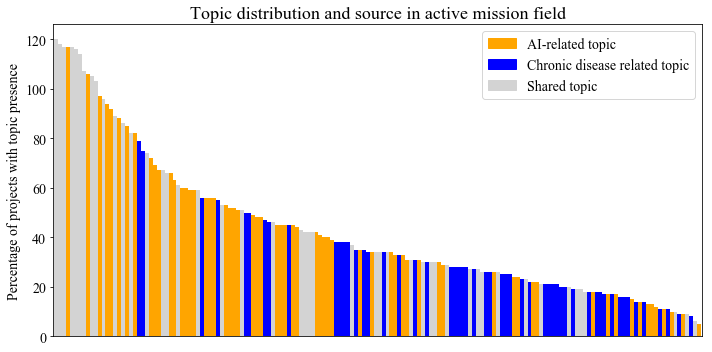

In [110]:
tm_sorted = tm_presences[0].sort_values(ascending=False)

fig,ax = plt.subplots(figsize=(10,5))

cols = ['orange' if ind in allocation['ai'] else 'blue' if ind in allocation['cd'] else 'lightgrey' for ind in tm_sorted.index]

tm_sorted.plot.bar(color=cols,width=1)

ax.legend(handles=[orange_patch,blue_patch,grey_patch],fontsize=14)

ax.yaxis.set_tick_params(labelsize=14)

ax.set_xticks([])

ax.set_ylabel('Percentage of projects with topic presence',fontsize=14)
ax.set_title('Topic distribution and source in active mission field',size=18)

plt.tight_layout()

plt.savefig('../reports/figures/presentation/topic_distribution.pdf')

### Visualise topic mix in each project in the mission field

In [114]:
#We focus on the active mission field

amf = mprof.sets[0]


#We focus on the active mission field

amf = mprof.sets[0]

#This extracts the number of projects with the topic in the year
# year_topics = pd.concat([
#     (tm.loc[list(amf.loc[amf['year']==y]['project_id'])]>0).sum() for y in np.arange(2006,2019)],axis=1)

year_topics = pd.concat([
    tm.loc[list(amf.loc[amf['year']==y]['project_id'])].sum() for y in np.arange(2006,2019)],axis=1)



year_topics.columns= np.arange(2006,2019)

#Here we sort IDs by category (AI, chronic disease etc) and by totals. 
sorted_ids = flatten_list([list(year_topics.loc[allocation[v]].sum(axis=1).sort_values(ascending=False).index) for v in ['ai','cd','shared']])

year_topics = year_topics.loc[sorted_ids]

In [ ]:
#Normalise topic mix so they always add to one (this is not strictly necessary)
amf_normalised = tm.loc[amf.project_id].apply(lambda x: x/x.sum(),axis=1)

#Sort projects (get AI intensive projects first)
projects_sorted_ai = list(amf_normalised[allocation['ai']].sum(axis=1).sort_values(ascending=False).index)

#Plot
amf_to_plot = amf_normalised.loc[projects_sorted_ai,sorted_ids]


fig,ax = plt.subplots()

cols_proj = ['orange' if ind in allocation['ai'] else 'blue' if ind in allocation['cd'] else 'lightgrey' for ind in amf_to_plot.columns]

#amf_to_plot.T.plot.bar(stacked=True,legend=False,ax=ax,color=cols_proj,edgecolor='black',linewidth=0.1,width=1)

amf_to_plot.T.plot.bar(stacked=True,legend=False,ax=ax)




#amf_normalised[sorted_ids]

### Print some of the topics

In [1244]:
# #Here we sort IDs by category (AI, chronic disease etc) and by totals. 


# topics_by_category = [list(year_topics.loc[allocation[v]].sum(axis=1).sort_values(ascending=False).index) for v in ['ai','cd','shared']]


# for x,n in zip(topics_by_category,['ai','cd','shared']):
    
#     print(n)
#     print('====')
    
#     print('high')
#     print('====')
#     for y in x[:10]:

#          print(model.topics(l=0,n=5)[y])
    
    
#         print('\n')
    
#     print('low')
#     print('====')
#     for y in x[-20:]:
        
#         print(model.topics(l=0,n=5)[y])
    
    
#         print('\n')
    

### Check evolution of activity over time

Here we want to look at the evolution of the distributio of topics over time

In [1167]:
#We focus on the active mission field

amf = mprof.sets[0]

#This extracts the number of projects with the topic in the year
# year_topics = pd.concat([
#     (tm.loc[list(amf.loc[amf['year']==y]['project_id'])]>0).sum() for y in np.arange(2006,2019)],axis=1)

year_topics = pd.concat([
    tm.loc[list(amf.loc[amf['year']==y]['project_id'])].sum() for y in np.arange(2006,2019)],axis=1)



year_topics.columns= np.arange(2006,2019)

In [1168]:
#Here we sort IDs by category (AI, chronic disease etc) and by totals. 
sorted_ids = flatten_list([list(year_topics.loc[allocation[v]].sum(axis=1).sort_values(ascending=False).index) for v in ['ai','cd','shared']])

year_topics = year_topics.loc[sorted_ids]

In [ ]:
year_topics_2 = pd.concat([
    (tm.loc[list(amf.loc[amf['year']==y]['project_id'])]>0).sum() for y in np.arange(2006,2019)],axis=1)
year_topics_2.columns= np.arange(2006,2019)

entropy_series= pd.concat(
    [year_topics_2.loc[allocation[var]].apply(lambda x: x/x.sum(),axis=0).apply(lambda x: entropy(x)) for var in ['cd','ai']],axis=1)

entropy_series.columns = ['chronic disease related topics','AI-related topics']


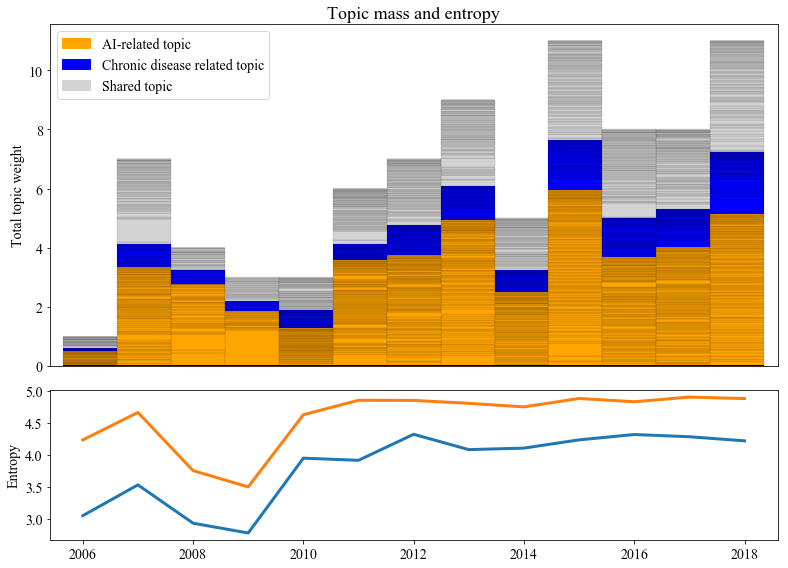

In [1184]:
fig,ax = plt.subplots(figsize=(11,8),nrows=2,sharex=False,gridspec_kw={'height_ratios': [4, 1.75]})

cols_2 = ['orange' if ind in allocation['ai'] else 'blue' if ind in allocation['cd'] else 'lightgrey' for ind in year_topics.index]

year_topics.T.plot.bar(stacked=True,legend=False,ax=ax[0],color=cols_2,edgecolor='black',linewidth=0.1,width=1)

ax[0].set_ylabel('Total topic weight',fontsize=14)
ax[0].yaxis.set_tick_params(labelsize=14)
ax[0].xaxis.set_tick_params(labelsize=14)

ax[0].legend(handles=[orange_patch,blue_patch,grey_patch],fontsize=14)
ax[0].set_title('Topic mass and entropy',size=18)
ax[0].set_xticks([])

entropy_series.plot(ax=ax[1],linewidth=3,legend=False)


ax[1].yaxis.set_tick_params(labelsize=14)
ax[1].xaxis.set_tick_params(labelsize=14)
ax[1].set_ylabel('Entropy',fontsize=14)

plt.tight_layout()

plt.savefig('../reports/figures/presentation/topic_evol.png')


In [739]:
# Step 3: Compare topics between groups: what's overrepresented in the active mission field and what isn't

# Step 4: Analyse content from topics

# Step 5: Analyse evolution over time

# Step 6: Analyse funder involvement (?)

## Doc2Vec project expansion

We train a doc2vec model that looks for projects which are semantically closed to those we identify as highly relevant for the challenge

In [541]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import normalize

In [417]:
tagged_documents = [TaggedDocument(doc,[num]) for num,doc in enumerate(corpus_tokenised.tokenised)]

In [534]:
d2v = Doc2Vec(tagged_documents,vector_size=500)

### Identify active mission field projects

In [624]:
mission_set_indices = set(flatten_list([x.index for x in mprof.sets]))

In [625]:
mission_document_vectors = pd.DataFrame(
    normalize(pd.concat([pd.Series(x) for num,x in enumerate(d2v.docvecs.vectors_docs) if num in mission_set_indices],axis=1).T))

In [626]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud


## Mission field decomposition

In [627]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift,SpectralClustering
#als = list(ec.cluster_allocations.values())
import wordcloud
import networkx as nx
from itertools import combinations, product
import community
import random

class EnsembleClustering():
    '''
    This class takes a group of vectors and clusters them using a variety of algorithms. 
    It then builds a network based on these allocations which we can use for community detection.
    
    input: a df where rows = observations to cluster and columns = vector for clustering
    methods:
        run_clusters: runs a variety of clustering algorithms with parameters defined by the user
        build_network: builds the network using the clustering results
        partitition_network: extracts communities from the network
    
    '''
    
    def __init__(self,vectors):
        '''
        Takes the vectors 
        '''
        
        #Stores the vectors
        self.vector_df = vectors
        
    def run_clusters(self,cluster_list):
        '''
        Each element in the cluster_list is a cluster algorithm and a dict with parameters. We do a cartesian product of these parameters or parameter lists
        to produce a list of cluster algorithms to run and store all the allocations.
        
        '''
        
        #Load vectors
        vectors = self.vector_df
        
        #Create store
        self.cluster_allocations = {}
        
        #For each cluster family we want to test
        for element in cluster_list:
            
            #Extract the algorithm, name and cluster parameters
            cluster_algo = element[0]
            
            cluster_name = element[1]
            
            cluster_params = element[2]
            
            #Create a grid
            grid = list(product(*cluster_params.values()))
            
            #print(grid)
            
            #For each element in the grid
            
            for conf in grid:
                
                #Create a keyword argument
                par_dict = {n:v for n,v in zip(cluster_params.keys(),conf)}
                
                #Initialise the clustering algorithm
                cl = cluster_algo(**par_dict)
                
                #print(cl)
                
                #Predict labels
                labs = cl.fit_predict(vectors)
                
                #Store labels
                self.cluster_allocations[cluster_name+'_'+str(conf)] = labs
                
        return(self)
    
    def build_network(self,verbose=False):
        '''
        Builds the network
        
        '''
        
        #net = nx.Graph()
        
        edges = []
        
        for n,result in enumerate(self.cluster_allocations.values()):
            
            if verbose==True:
                print(n)
            
            grouped = pd.DataFrame({'index':ec.vector_df.index,'allocs':result}).groupby('allocs')['index'].apply(lambda x:list(x))
            
            combs = flatten_list([['__'.join([str(x) for x in var]) for var in combinations(vals,2)] for vals in grouped])
            
            edges.append(combs)
            
        
        edge_list = flatten_list(edges)
        
        
        combs_df = pd.Series(edge_list).value_counts().reset_index(drop=False)

        combs_df.columns = ['vars','weight']
        
        #This is an edgelist
        combs_df['source'],combs_df['target'] = [[x.split('__')[num] for x in combs_df['vars']] for num in [0,1]]


        combs_df.drop(['vars'],axis=1,inplace=True)
        
        #Create a network
        self.network = nx.from_pandas_edgelist(combs_df,edge_attr='weight')
            
        
    
    def partitition_network(self,resolution=1):
        '''
        
        Partitions the network
        
        '''
        
        part = community.best_partition(self.network,resolution=resolution)
        
        
        allocs = pd.Series(part)
        allocs.name = 'clusters'
        
        allocs.index = [int(x) for x in allocs.index]
        
        self.partition = allocs           

        
class SalientWords():
    '''
    Class that extracts salient words from clusters of data.
    
    Arguments:
        A dataframe and two strings (the variable to groupby and the variable to use as text)
        
    Methods:
        .count_vect(): word frequencies for all words (takes **kwargs for additional parameters in the count vectorisation)
        .salient(): tfidf. It will also take **kwargs and a threshold for including words in the results
        .visualise(): it visualises the data as wordclouds
    
    '''
    
    def __init__(self,df,categories,text):
        '''
        Initialises with key variables
        
        '''    
        
        
        #This creates the joined corpus
        self.grouped_corpus = df.groupby(categories)[text].apply(lambda x: ' '.join(x))
        
        
        #Remove digits and special 
        dig = r'|'.join(st.digits)
        out = '\W+'
        
        self.processed_text = [re.sub(out,' ',re.sub(dig,' ',x.lower())) for x in self.grouped_corpus]
        
        #This is a dict we will use to store the results later
        self.groups = {i:[] for i in self.grouped_corpus.index}
        
        #return(self)
        
    def word_freqs(self,**kwargs):
        '''
        Terms frequencies over categories
        
        '''
        #load corpus
        X = self.processed_text
        
        count_vect = CountVectorizer(**kwargs)
        
        #Store outputs
        self.count_vect = count_vect
        self.token_freqs = count_vect.fit_transform(X)
        
        return(self)
    
    def salient(self,min_threshold=1000,extra_stops=['research','project','new','projects'],**kwargs):
        '''
        Salient terms in the data.
        
        '''
        
        #Get selected words
        
        word_freqs = pd.DataFrame(self.token_freqs.todense(),columns=self.count_vect.get_feature_names())
        
        word_freqs_total = word_freqs.sum(axis=0)
        
        #Create a dict so we can put word frequencies together with salient words later
        #word_freqs_dict = word_freqs.to_dict()
        
        #I am interested in any words above the threshold
        my_words = [x for x in word_freqs_total.index[word_freqs_total>min_threshold] if x not in extra_stops]
        
        
        #Initialise the tfidf
        tf = TfidfTransformer(**kwargs)
        
        
        #out
        X = tf.fit_transform(self.token_freqs)
        
        X_selected = pd.DataFrame(X.todense(),columns=self.count_vect.get_feature_names())[my_words]
            
            
        #Store the results
        for n,x in enumerate(self.groups.keys()):
            
            #Creates the dataframe combining tfs and wfs
            result = pd.concat([X_selected.iloc[n],word_freqs.iloc[n][my_words]],axis=1)
            
            result.columns = ['tfidf','count'] 
                   
            self.groups[x] = result
            
        return(self)
        
    def get_summary(self,tf_threshold=90,wf_threshold=75):
        '''
        
        Extracts a summary of the data based on tf and wf thresholds
        
        '''
        
        self.summary={i:[] for i in self.groups.keys()}
        
        for x in self.groups.keys():
            
            #Creates the dataframe
            result = self.groups[x]
            
            tf_thres = np.percentile(result['tfidf'],tf_threshold)
            
            summary = result.loc[result['tfidf']>tf_thres]
            
            wf_thres = np.percentile(result['count'],wf_threshold)
            
            summary_2 = summary.loc[summary['count']>wf_thres]
                   
            self.summary[x] = summary_2.sort_values('tfidf',ascending=False)
        
        return(self)
    
def make_wordcloud(term_freqs_df,var,name,ax):
    '''
    This function takes a df generated by the SalientWords class and returns a wordcloud
    
    '''
    
    input_dict = {w:f for w,f in zip(term_freqs_df.index,term_freqs_df[var])}

    wc = wordcloud.WordCloud(background_color="black").generate_from_frequencies(input_dict)

    ax.imshow(wc)
    
    ax.axis('off')
    
    ax.set_title(name)

In [630]:
cluster_list = [[KMeans,'kmeans',{'n_clusters':np.arange(10,40,2),'max_iter':[250,500]}],
                #[MeanShift,'ms',{'cluster_all':[True,False]}],
               #[AgglomerativeClustering,'agglom',{'n_clusters':np.arange(5,20,1)}],
                #[SpectralClustering,'spec',{'n_clusters':np.arange(5,40,1),'n_init':[10,20]}]
               ]
                

In [632]:
#ec = EnsembleClustering(pd.DataFrame(d2v.docvecs.vectors_docs))

ec = EnsembleClustering(mission_document_vectors)
ec.run_clusters(cluster_list)

In [567]:
ec.build_network()

In [604]:
ec.partitition_network(resolution=0.3)

In [605]:
partition = ec.partition

In [606]:
partition_sorted_lookup = partition[sorted(partition.index)].to_dict()

In [607]:
projects_salient = mission_projects.copy()

In [608]:
projects_salient['cluster'] = [partition_sorted_lookup[x] for x,y in enumerate(projects_salient.index)]

In [609]:
import string as st
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [610]:
traj_salient = SalientWords(df=projects_salient,categories='cluster',text='abstract')

In [614]:
traj_salient.word_freqs(**{'stop_words':'english','max_features':20000,'ngram_range':(1,3),'max_df':4}).salient(min_threshold=5).get_summary(
    wf_threshold=50,tf_threshold=75)

In [615]:
len(traj_salient.summary)

11

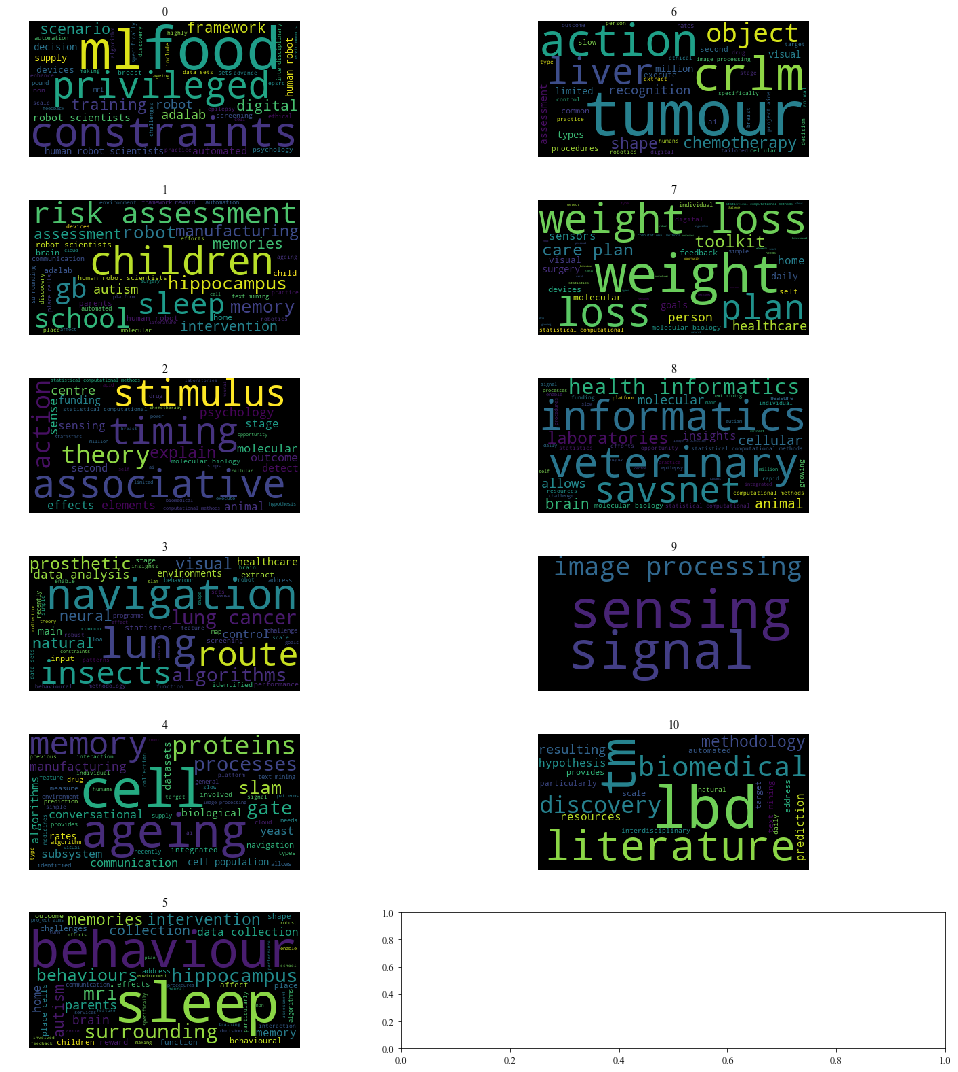

In [616]:
rows=6

fig,ax = plt.subplots(ncols=2,nrows=rows,figsize=(15,15))

for n,name in enumerate(traj_salient.summary.keys()):
    
    #print(n)
    
    if n<rows:
        make_wordcloud(traj_salient.summary[name],'tfidf',name,ax=ax[n][0])
        
    else:
        make_wordcloud(traj_salient.summary[name],'tfidf',name,ax=ax[n-rows][1])
        
plt.tight_layout()